In [1]:
import numpy as np
from clothing_classifier import get_clothing_vector_model, get_img_vectors
from clothing_classifier import get_product_to_features, get_bottom_feature_indexes
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from keras import optimizers
from sklearn.model_selection import train_test_split
from collections import defaultdict
import db.db as db
from sklearn.neighbors import KDTree, NearestNeighbors
import cv2
import urllib.request
import matplotlib.pyplot as plt

from itertools import permutations, combinations

%matplotlib inline

Using TensorFlow backend.


In [2]:
classifier_vector_model = get_clothing_vector_model()

Loaded model from disk


In [3]:
jeans_img_path = 'data-all/validation/jeans/482888849.jpg'
dress_img_path = 'data-all/validation/dresses/535993294.jpg'
jackets_img_path = 'data-all/validation/jackets/614521319.jpg'
jackets_img_path2 = 'data-all/validation/jackets/614763686.jpg'
sunglasses_img_path = 'data-all/validation/sunglasses/655241570.jpg'

jacket_feat = get_img_vectors(classifier_vector_model, jackets_img_path)
jacket_feat2 = get_img_vectors(classifier_vector_model, jackets_img_path2)
jeans_feat = get_img_vectors(classifier_vector_model, jeans_img_path)
dress_feat = get_img_vectors(classifier_vector_model, dress_img_path)

dress_feat.shape

(1024,)

In [4]:
# compare cosine similarities
print('2 jackets: ', cosine_similarity([jacket_feat], [jacket_feat2]))
print('jeans and dress: ', cosine_similarity([jeans_feat], [dress_feat]))

2 jackets:  [[ 0.97938681]]
jeans and dress:  [[ 0.97675431]]


In [5]:
# compare euclidean distances
print('2 jackets: ', euclidean_distances([jacket_feat], [jacket_feat2]))
print('jeans and dress: ', euclidean_distances([jeans_feat], [dress_feat]))

2 jackets:  [[ 9.2059164]]
jeans and dress:  [[ 16.56675911]]


In [6]:
jacket_feat.shape # (1, 1024)

(1024,)

## Outfit Recommendations

In [7]:
FEATURE_COUNT=850
BOTTOM_FEATURE_INDEXES = get_bottom_feature_indexes(number_features_to_keep=FEATURE_COUNT)

def get_product_to_collections():
    collection_products = db.get_collection_products()
    product_to_collections = defaultdict(set)
    for cp in collection_products:
        collection_id = str(cp[0])
        product_id = str(cp[1])
        product_to_collections[product_id].add(collection_id)
    return product_to_collections


def get_closest_products(input_features, model, index_to_prod_mapping, count=15):
    """Only allow one product at a time"""
    product_distances, product_indexes = model.kneighbors(input_features, count, return_distance=True)
    closest_product_ids = [index_to_prod_mapping[index] for index in product_indexes[0]]
    return closest_product_ids, product_distances[0]


def get_product_category_to_type():
    return {'jeans': 'bottom',
            'shorts': 'bottom',
            'womens-pants': 'bottom',
            'skirts': 'bottom',
            'dresses': 'dress',
            'womens-tops': 'top',
            'sweaters': 'top',
            'sweatshirts': 'top',
            'jackets': 'coat',
            'womens-outerwear': 'coat',
            'handbags': 'accessories',
            'hats': 'accessories',
            'jewelry': 'accessories',
            'sunglasses': 'accessories',
            'womens-shoes': 'accessories'}


def is_valid_combo(types):
    is_invalid = (types.count('top') >= 2) or \
                 (types.count('bottom') >= 2) or \
                 (types.count('coat') >= 2) or \
                 (types.count('shoes') >= 2) or \
                 (types.count('dress') >= 2) or \
                 (types.count('accessories') > 2) or \
                 (types.count('dress') >= 1 and
                  types.count('bottom') >= 1) or \
                 (types.count('dress') >= 1 and
                  types.count('top') >= 1) or \
                 (types.count('accessories') == 1 and
                  len(types) == 2 and
                  types.count('top') == 1) or \
                 (types.count('accessories') >= 1 and
                  len(types) == 2 and
                  types.count('bottom') >= 1)

    return not is_invalid

def get_wardrobe_closest_collections(wardrobe_items, nn_model, 
                                     index_to_prod_mapping, prod_to_collection_mapping):
    """For every item in an wardrobe, get closest Shopstyle products
    used in curated collections and then corresponding collections"""
    wardrobe_closest = {}
    for item in wardrobe_items:
        item_id = item['item_id']
        input_features = np.array(item['image_vector'])
        input_features_reduced = np.array([np.delete(input_features, BOTTOM_FEATURE_INDEXES)])
        closest_prods, prod_dists = get_closest_products(input_features_reduced, nn_model, 
                                                         index_to_prod_mapping, count=500)
        collection_ids_for_item = {}
        for prod_id, dist in zip(closest_prods, prod_dists):
            if dist < 6:
                collection_ids = prod_to_collection_mapping.get(prod_id, [])
                for cid in collection_ids:
                    collection_ids_for_item[cid] = dist
        wardrobe_closest[item_id] = collection_ids_for_item
    return wardrobe_closest

# Get permutations of items in wardrobe
def get_wardrobe_combinations(wardrobe_items):
    category_to_types = get_product_category_to_type()
    combos2 = list(combinations(wardrobe_items, 2))
    combos3 = list(combinations(wardrobe_items, 3))
    combos4 = list(combinations(wardrobe_items, 4))
    all_combos = combos2 + combos3 + combos4
    valid_combos = []
    for combo in all_combos:
        combo_types = [category_to_types[p['category']] for p in combo]
        if is_valid_combo(combo_types):
            valid_combos.append(combo)
    return valid_combos                

In [8]:
prod_to_colls = get_product_to_collections()

In [9]:
product_feats_file = 'data-outfits/products_features.tsv'
prods_to_feats = get_product_to_features(product_feats_file=product_feats_file, number_features_to_keep=FEATURE_COUNT)

In [10]:
len(prods_to_feats['641336745'][0])

850

In [11]:
def display_images(image_paths):
    image_count = len(image_paths)
    fig, ax = plt.subplots(1, image_count, figsize=(image_count*5, 4))
    
    if image_count == 1:
        image_file = image_paths[0]
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    
        plt.imshow(image, interpolation='nearest')
        plt.axis("off")
    else: 
        for i, image_file in enumerate(image_paths):
            image = cv2.imread(image_file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    
            ax[i].imshow(image, interpolation='nearest')
            ax[i].axis("off")
    plt.show()

def display_url_images(image_urls):
    image_count = len(image_urls)
    
    if image_count == 1:
        image_url = image_urls[0]
        req = urllib.request.urlopen(image_url)
        arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
        img = cv2.imdecode(arr,-1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.axis("off")
    else: 
        fig, ax = plt.subplots(1, image_count, figsize=(image_count*5, 4))
        for i, image_url in enumerate(image_urls):
            req = urllib.request.urlopen(image_url)
            arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
            img = cv2.imdecode(arr,-1)
            # Correct BGR to RGB channel
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax[i].imshow(img)
            ax[i].axis("off")
    plt.show()

    
def display_product_images(product_ids):
    image_files = ['images/images_collection_products/' + product_id + '.jpg' for product_id in product_ids]
    display_images(image_files)

    
def make_nn_model():
    """Return Nearest Neighbors model fitted on products in curated collections"""
    index_to_prod = {}
    prod_features = []
    for i, prod_feat in enumerate(prods_to_feats.items()):
        prod_id, feat = prod_feat
        index_to_prod[i] = prod_id
        prod_features.append(feat[0])
    prod_features = np.array(prod_features)
    print('Making Nearest Neighbors ...')
    nn_model = NearestNeighbors(n_neighbors=500, metric='l2', algorithm='auto')
    nn_model.fit(prod_features)
    return nn_model, index_to_prod, prod_features

neighbors_model, index_to_prod, prod_features = make_nn_model()

Making Nearest Neighbors ...


In [12]:
neighbors_model.kneighbors(prod_features[:3], 5, return_distance=True)

(array([[ 0.        ,  6.32361795,  6.32563764,  6.86316039,  6.92351359],
        [ 0.        ,  4.13092797,  4.42651747,  4.68785187,  4.88931186],
        [ 0.        ,  3.1479757 ,  3.54396796,  3.73335517,  3.76150892]]),
 array([[    0, 60416, 28784, 54981,  8676],
        [    1, 29749, 15053, 47602, 12873],
        [    2, 49419, 33299, 24297,  2764]]))

In [13]:
setlist = [set([1, 2, 3, 4]), set([4, 5]), set([3, 4, 6]), set([5, 4])]
intersectedSet = None
for s in setlist:
    if intersectedSet is None:
        intersectedSet = s
    else:
        print(intersectedSet)
        intersectedSet = set.intersection(intersectedSet, s)
    
intersectedSet

{1, 2, 3, 4}
{4}
{4}


{4}

In [14]:
prod_to_colls['4427']

{'42928400'}

In [38]:
def get_wardrobe_combo_collections():
    """Return collections that match a combination most closely"""
    conn = db.make_db_conn()
    user_id = '5221de0a-cd0c-45a3-ac66-d1a6339ab446'
    wardrobe_items = db.get_wardrobe_items(conn, user_id)
    
    items_to_collections = get_wardrobe_closest_collections(wardrobe_items, neighbors_model, 
                                     index_to_prod, prod_to_colls)
    
    valid_combos = get_wardrobe_combinations(wardrobe_items)
    combo_to_closest_collections = {}
    for combo in valid_combos:
        combo_id = tuple([(str(item['item_id']), item['image_url']) for item in combo])
        collection_matches = None
        collection_match_to_distance = {}
        for item in combo:
            item_id = item['item_id']
            category = item['category']
            collections_dists_for_item = items_to_collections[item_id]
            collections_for_item = set(collections_dists_for_item.keys())
            if collection_matches is None:
                collection_matches = collections_for_item
            else:
                collection_matches = set.intersection(collection_matches, collections_for_item)
                
            # Find closest collections for combination
            for collection_id in collection_matches:
                coll_dist = collection_match_to_distance.get(collection_id, 0) + collections_dists_for_item[collection_id]
                collection_match_to_distance[collection_id] = coll_dist
        if len(collection_matches) > 0:      
            collection_distances = [(coll_id, collection_match_to_distance[coll_id]) for coll_id in collection_matches]
            collection_distances = sorted(collection_distances, key=lambda tup: tup[1])
            combo_to_closest_collections[combo_id] = collection_distances
    return combo_to_closest_collections
    

def sort_matching_collections():
    """Get matching collections sorted by distance"""
    sorted_matches = []
    matching_collections = get_wardrobe_combo_collections()
    for combo_id, closest_collections in matching_collections.items():
        if len(closest_collections) > 0:
            closest_collection = closest_collections[0]
            closest_collection_id = closest_collection[0]
            closest_collection_distance = closest_collection[1]
            collection_average_dist = closest_collection_distance / float(len(combo_id))
            # Maximum average distance
            if collection_average_dist < 5.20:
                sorted_matches.append([combo_id, closest_collection_id, collection_average_dist])
    sorted_matches = sorted(sorted_matches, key=lambda tup: tup[-1])
    return sorted_matches


def combos_to_collections():
    closest_matches = sort_matching_collections()
    collection_to_combo = defaultdict(list)
    collection_to_smallest_dist = {}
    for combo_id, closest_collection_id, collection_average_dist in closest_matches:
        collection_to_combo[closest_collection_id].append(combo_id)
        curr_smallest_dist = collection_to_smallest_dist.get(closest_collection_id, None)
        if (curr_smallest_dist is None) or (collection_average_dist < curr_smallest_dist):
            collection_to_smallest_dist[closest_collection_id] = collection_average_dist
            
    sorted_collections = sorted(collection_to_smallest_dist.items(), key=lambda tup: tup[1])
    return collection_to_combo, sorted_collections
        
# matching_collections = get_wardrobe_combo_collections()
# for combo_id, closest_collections in matching_collections.items():
#     print('Found ', len(closest_collections), ' matches for ', [i[0] for i in combo_id])
#     display_url_images([c[1] for c in combo_id])
#     if len(closest_collections) > 0:
#         display_count = max(2, len(closest_collections))
#         print(closest_collections[:display_count])
#         collection_paths = ['images/images_collections/' + c[0] + '.jpg' for c in closest_collections]
#         display_images(collection_paths[:display_count])

Matching collection  42916546  Distance:  4.26353756462


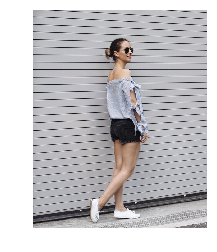

Items:  ['d06a0601-010d-48b3-ad1d-1712fce70c90', '85f26b4f-a4d5-4ad4-bbbb-fbcc0739757e']


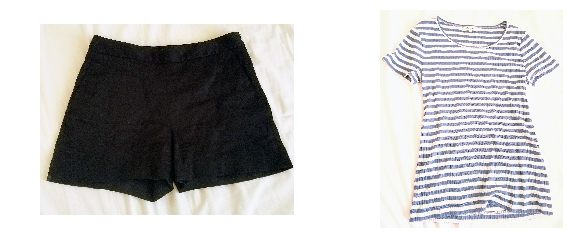

Matching collection  42926514  Distance:  4.68313157761


Items:  ['b23c8dd6-d0f3-4312-a4af-0d4bc76f7bb5', '10b759f3-9e26-45ad-b0c2-6ff7a092d5d1']


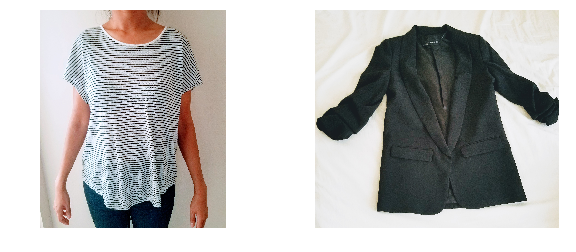

Items:  ['b23c8dd6-d0f3-4312-a4af-0d4bc76f7bb5', 'c52becb8-0617-4a69-a5be-fd11100132bb']


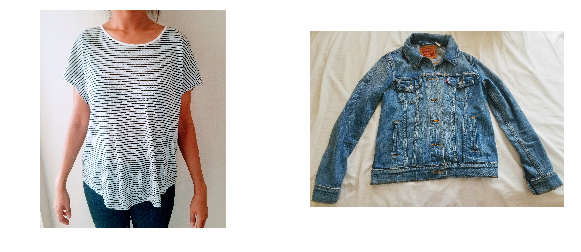

Matching collection  42829042  Distance:  4.72022545013


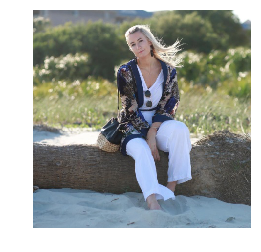

Items:  ['af1df891-aa06-4993-8100-d11bbb3fda88', 'b23c8dd6-d0f3-4312-a4af-0d4bc76f7bb5']


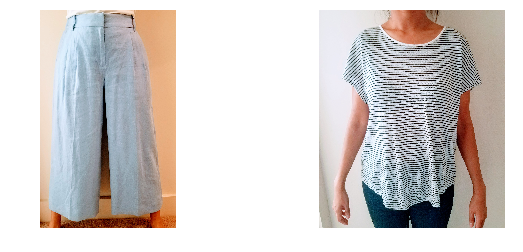

Items:  ['af1df891-aa06-4993-8100-d11bbb3fda88', '85f26b4f-a4d5-4ad4-bbbb-fbcc0739757e']


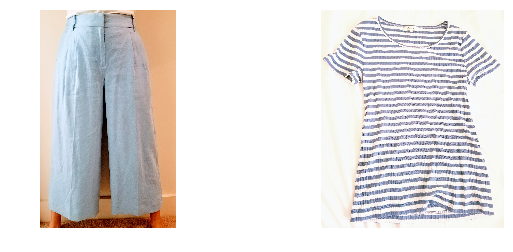

Matching collection  42929905  Distance:  4.93514204309


Items:  ['dc4bd686-9d9c-4acc-b47e-a382d6c68fa4', '10b759f3-9e26-45ad-b0c2-6ff7a092d5d1']


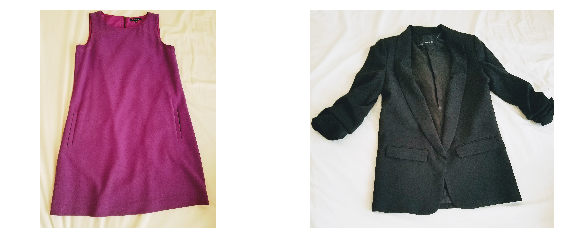

Items:  ['dc4bd686-9d9c-4acc-b47e-a382d6c68fa4', 'c52becb8-0617-4a69-a5be-fd11100132bb']


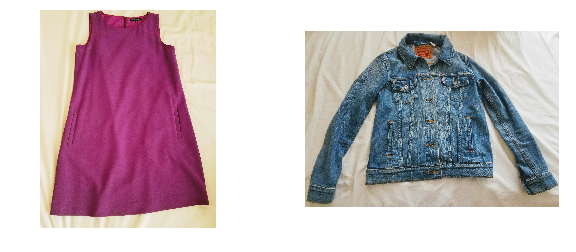

Matching collection  42709727  Distance:  4.95592498335


Items:  ['3468fb22-4b6e-4464-9d38-42b837628a30', 'b23c8dd6-d0f3-4312-a4af-0d4bc76f7bb5']


Matching collection  42935110  Distance:  4.9588220372


Items:  ['dfd93d92-f61c-42a8-a791-0abba2d072a3', 'af1df891-aa06-4993-8100-d11bbb3fda88']


Matching collection  42918212  Distance:  5.01334306478


Items:  ['dfd93d92-f61c-42a8-a791-0abba2d072a3', '0bed4011-6705-4fa2-854a-0b095a31087f']


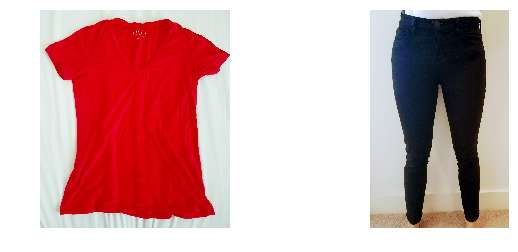

Matching collection  42926554  Distance:  5.01928379846


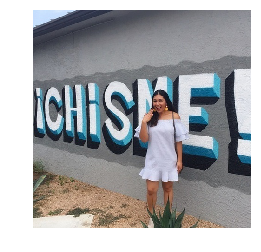

Items:  ['dc4bd686-9d9c-4acc-b47e-a382d6c68fa4', '48997f53-1aca-4b87-b537-13a392a8ee74']


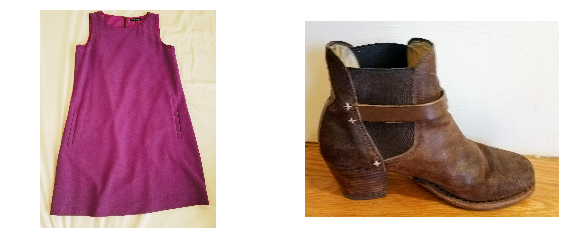

Matching collection  42841726  Distance:  5.12703145683


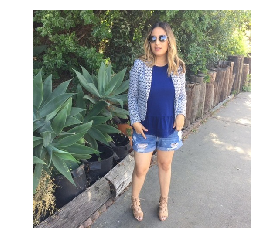

Items:  ['d06a0601-010d-48b3-ad1d-1712fce70c90', '10b759f3-9e26-45ad-b0c2-6ff7a092d5d1']


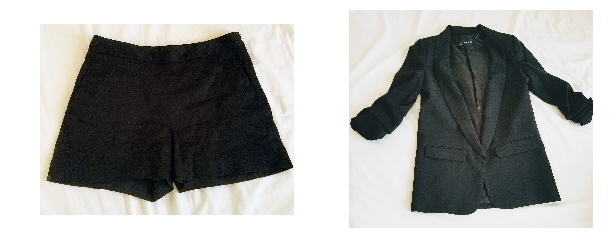

Matching collection  42932207  Distance:  5.18488444066


Items:  ['0bed4011-6705-4fa2-854a-0b095a31087f', 'b23c8dd6-d0f3-4312-a4af-0d4bc76f7bb5']


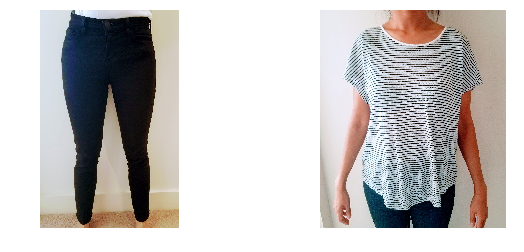

Matching collection  42936323  Distance:  5.19394102155


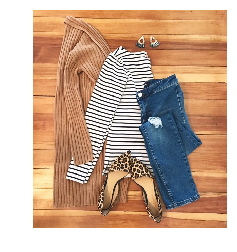

Items:  ['3468fb22-4b6e-4464-9d38-42b837628a30', '85f26b4f-a4d5-4ad4-bbbb-fbcc0739757e']


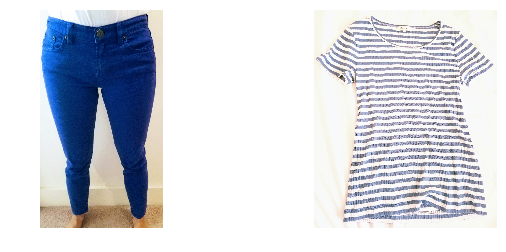

In [39]:
matching_results, sorted_colls = combos_to_collections()

for collection_id, shortest_dist in sorted_colls:
    print('Matching collection ', collection_id, ' Distance: ', shortest_dist)
    combos = matching_results[collection_id]
    collection_paths = ['images/images_collections/' + collection_id + '.jpg']
    display_images(collection_paths)
    for combo in combos:
        item_ids = [i[0] for i in combo]
        item_urls = [i[1] for i in combo]
        print('Items: ', item_ids)
        display_url_images(item_urls)
    
    

In [ ]:
white_shirt_id = '625552248'
pink_bag_id = '430848442'
display_product_images([white_shirt_id, pink_bag_id])

In [ ]:
white_shirt_vector = prods_to_feats[white_shirt_id]
closest_white_shirt_ids, closest_white_shirt_distances = get_closest_products(white_shirt_vector, neighbors_model, index_to_prod, count=1000)
display_product_images(closest_white_shirt_ids[:15])
closest_white_shirt_distances[:15]

In [ ]:
# furthest white shirts
furthest_white_shirt_ids = closest_white_shirt_ids[::-1]
furthest_white_shirt_distances = closest_white_shirt_distances[::-1]
display_product_images(furthest_white_shirt_ids[900:915])
furthest_white_shirt_distances[900:915]

In [ ]:
pink_bag_vector = prods_to_feats[pink_bag_id]
closest_pink_bag_ids, closest_pink_bag_dists= get_closest_products(pink_bag_vector, neighbors_model, index_to_prod)
display_product_images(closest_pink_bag_ids)
closest_pink_bag_dists

In [ ]:
conn = db.make_db_conn()

In [ ]:
nana_user_id = '5221de0a-cd0c-45a3-ac66-d1a6339ab446'
test_wardrobe_items = db.get_wardrobe_items(conn, nana_user_id)
test_wardrobe_item_to_feat = {}
for i in test_wardrobe_items:
    test_wardrobe_item_to_feat[str(i['item_id'])] = {'vector': i['image_vector'], 
                                                     'url': i['image_url'],
                                                     'category': i['category']}
    
for test_item_id in test_wardrobe_item_to_feat.keys():
    test_feat = test_wardrobe_item_to_feat[test_item_id]['vector']
    test_image_url = test_wardrobe_item_to_feat[test_item_id]['url']
    test_image_category = test_wardrobe_item_to_feat[test_item_id]['category']
    print(test_item_id, ' / ', test_image_category)
    display_url_images([test_image_url, test_image_url])
    test_feat_reduced = np.array([np.delete(test_feat, BOTTOM_FEATURE_INDEXES)])
    closest_test_ids, closest_test_dists= get_closest_products(test_feat_reduced, neighbors_model, index_to_prod)
    display_product_images(closest_test_ids)
    closest_test_dists

In [ ]:
[prod_to_colls[pid] for pid in closest_test_ids]